# Installing Detectron2

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
'''!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))'''

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-qbz9qbc_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-qbz9qbc_
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Install required libraries
!pip install pycocotools matplotlib

# Dataset Visualization

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


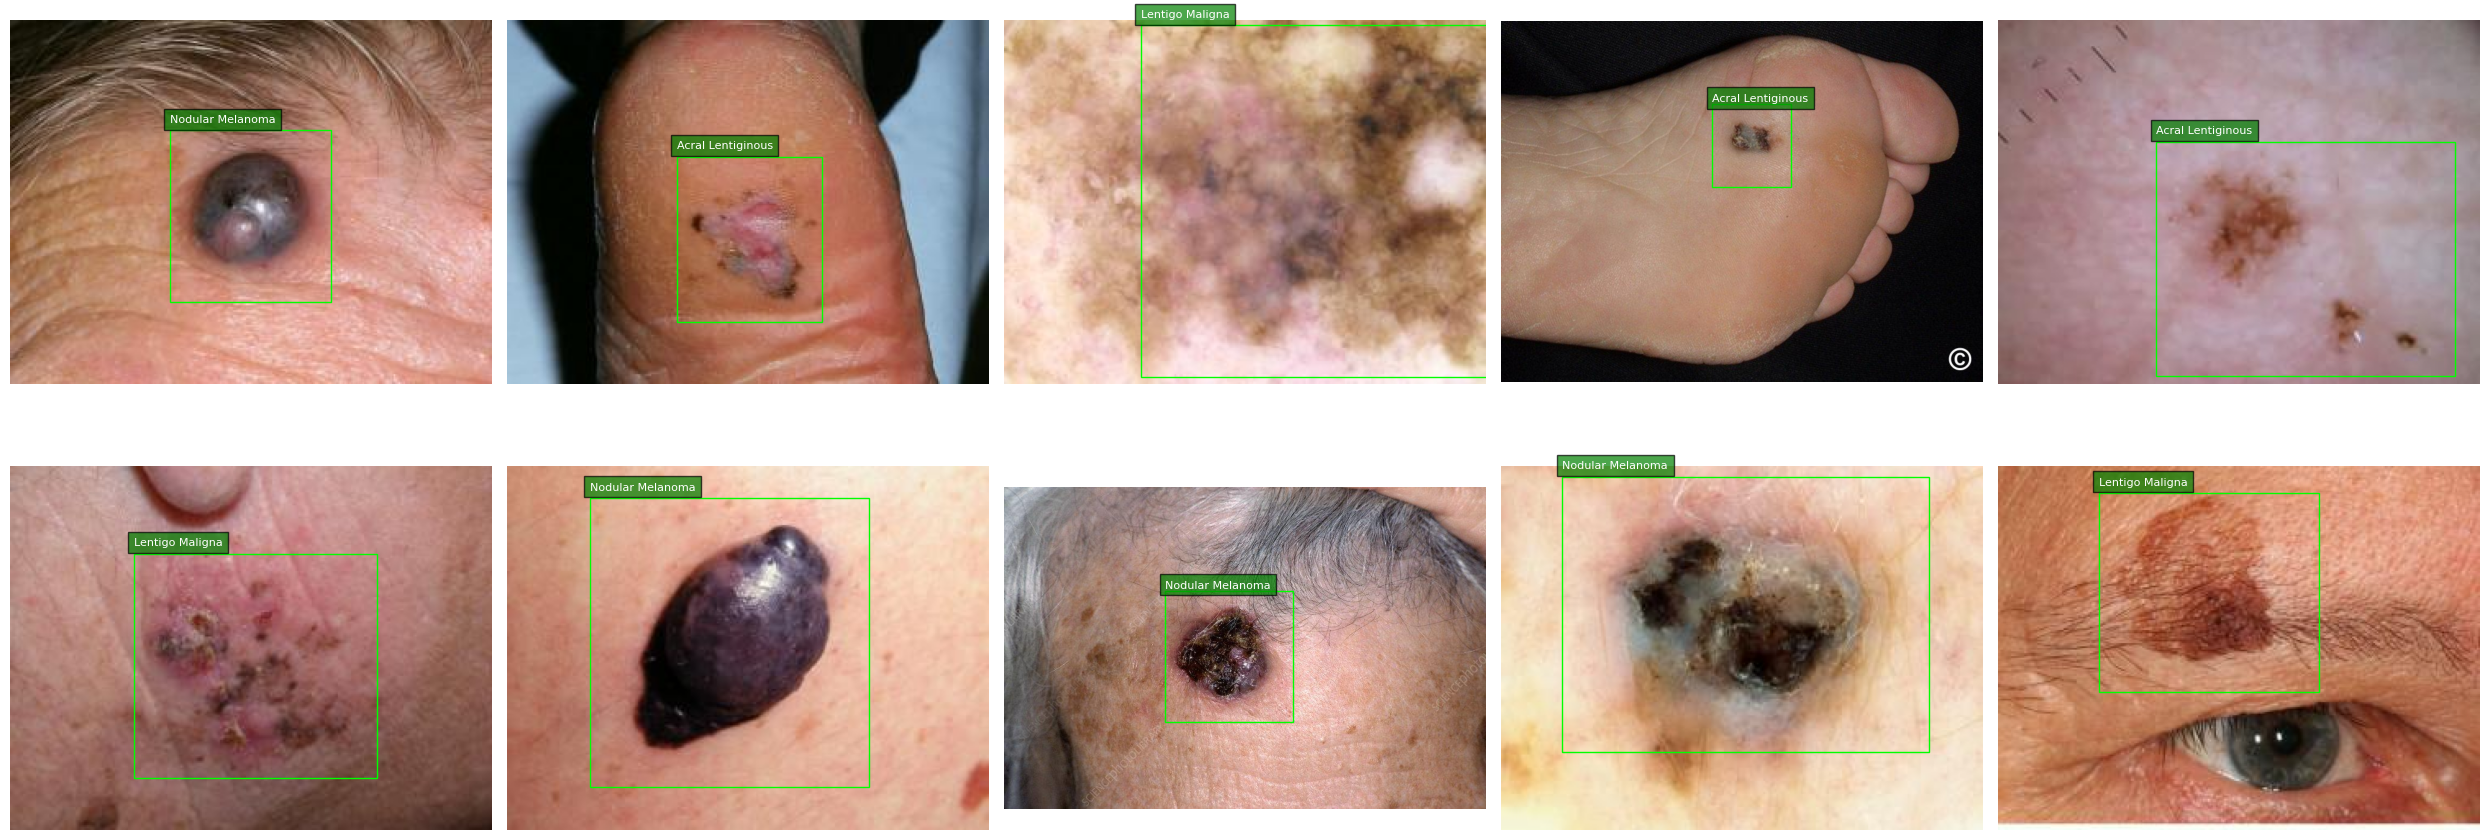

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
import os
import cv2
import random


# Path configurations (modify according to your structure)
data_dir = '/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco'  # Path to your dataset root
train_ann_file = os.path.join(data_dir, 'train/_annotations.coco.json')  # COCO annotations file
train_img_dir = os.path.join(data_dir, 'train')  # Train images directory

# Initialize COCO API
coco = COCO(train_ann_file)

# Get all image ids and select random ones
image_ids = coco.getImgIds()
random_ids = random.sample(image_ids, 10)  # Select 10 images for 2 rows of 5

# Create figure with 2 rows and 5 columns
plt.figure(figsize=(25, 10))  # Wider figure to accommodate 5 columns

# Display images with bounding boxes
for i, img_id in enumerate(random_ids):
    # Get image info
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(train_img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(ann_ids)

    # Create subplot - 2 rows, 5 columns, position i+1
    ax = plt.subplot(2, 5, i+1)  # Changed to 2 rows, 5 columns
    plt.imshow(image)
    plt.axis('off')

    # Add bounding boxes and labels
    for ann in annotations:
        bbox = ann['bbox']
        category_id = ann['category_id']
        category_info = coco.loadCats(category_id)[0]

        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=1, edgecolor='lime', facecolor='none')  # Changed color to lime
        ax.add_patch(rect)

        plt.text(
            bbox[0], bbox[1]-5,
            category_info['name'],
            color='white', fontsize=8,
            bbox=dict(facecolor='green', alpha=0.7))  # Changed to green

plt.tight_layout()
plt.show()

# Importing LIbraries

In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_test_loader

# Train on a custom dataset

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/train/_annotations.coco.json", "/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/valid/_annotations.coco.json", "/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/valid")
register_coco_instances("my_dataset_test", {}, "/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/test/_annotations.coco.json", "/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/test")

In [7]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")
test_metadata = MetadataCatalog.get("my_dataset_test")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")


WARNING [04/07 15:45:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/07 15:45:54 d2.data.datasets.coco]: Loaded 157 images in COCO format from /kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/train/_annotations.coco.json
WARNING [04/07 15:45:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/07 15:45:54 d2.data.datasets.coco]: Loaded 45 images in COCO format from /kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/valid/_annotations.coco.json
WARNING [04/07 15:45:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/07 15:45:54 d2.data.datasets.coco]: Loaded 23 images in COCO format from /kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/test/_annotations.coco.json


# Sanity check

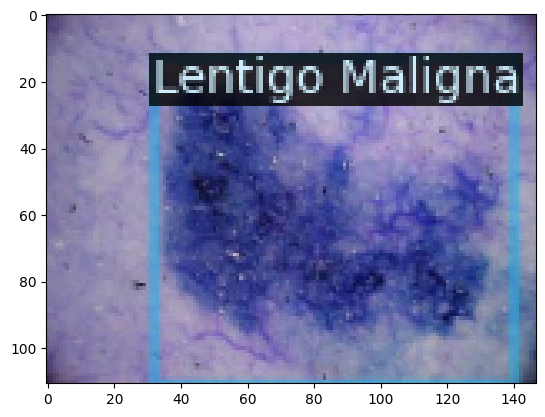

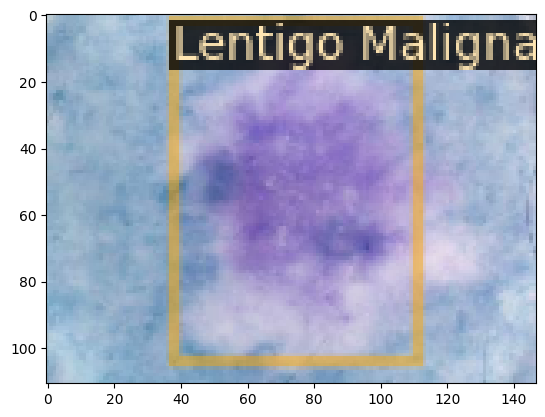

In [8]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Class ID 0: cancer (parent category)

Class ID 1: Acral Lentiginous (subclass of cancer)

Class ID 2: Lentigo Maligna (subclass of cancer)

Class ID 3: Nodular Melanoma (subclass of cancer)



In [9]:
import os

# Create a folder called "melanoma_detectron2"
folder_path = "/kaggle/working/retinanet"
os.makedirs(folder_path, exist_ok=True)

print(f"Folder created at: {folder_path}")

Folder created at: /kaggle/working/retinanet


In [10]:
# ==================== CONFIGURATION ====================
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.OUTPUT_DIR = "/kaggle/working/retinanet"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# Dataset
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Weights and training hyperparameters
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Pretrained RetinaNet
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 4000
cfg.SOLVER.STEPS = []  # No learning rate decay

# RetinaNet specific
cfg.MODEL.RETINANET.NUM_CLASSES = 4  # Update with your number of classes

# Evaluation period
cfg.TEST.EVAL_PERIOD = 200

# Create output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [11]:
# ==================== TRAINING ====================
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/07 15:45:56 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_5bd44e.pkl: 152MB [00:00, 210MB/s]                           


[04/07 15:45:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/07 15:46:09 d2.utils.events]:  eta: 0:23:17  iter: 19  total_loss: 1.478  loss_cls: 0.973  loss_box_reg: 0.4441    time: 0.4317  last_time: 0.3389  data_time: 0.0117  last_data_time: 0.0043   lr: 4.9953e-06  max_mem: 1671M
[04/07 15:46:29 d2.utils.events]:  eta: 0:23:28  iter: 39  total_loss: 1.57  loss_cls: 1.064  loss_box_reg: 0.5047    time: 0.4044  last_time: 0.4700  data_time: 0.0053  last_data_time: 0.0066   lr: 9.9902e-06  max_mem: 1908M
[04/07 15:46:37 d2.utils.events]:  eta: 0:23:54  iter: 59  total_loss: 1.569  loss_cls: 1.123  loss_box_reg: 0.4616    time: 0.4026  last_time: 0.4391  data_time: 0.0060  last_data_time: 0.0066   lr: 1.4985e-05  max_mem: 1908M
[04/07 15:46:45 d2.utils.events]:  eta: 0:23:47  iter: 79  total_loss: 1.686  loss_cls: 1.117  loss_box_reg: 0.5768    time: 0.3963  last_time: 0.3098  data_time: 0.0059  last_data_time: 0.0084   lr: 1.998e-05  max_mem: 1908M
[04/07 15:46:53 d2.utils.events]:  eta: 0:23:54  iter: 99  total_loss: 1.487  loss_cls: 1.039 

In [12]:
trainer.checkpointer.save("model_final")

In [13]:
# Save final config
with open(os.path.join(cfg.OUTPUT_DIR, "final_config.yaml"), "w") as f:
    f.write(cfg.dump())

In [14]:
# ==================== LOAD TRAINED MODEL ====================
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

[04/07 16:18:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/retinanet/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

# === EVALUATION ON TEST SET ===

In [15]:
# ==================== EVALUATION ON TEST SET ====================
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
metrics = inference_on_dataset(predictor.model, val_loader, evaluator)
print("Evaluation Metrics:", metrics)

WARNING [04/07 16:18:29 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/07 16:18:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/07 16:18:29 d2.data.datasets.coco]: Loaded 23 images in COCO format from /kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/test/_annotations.coco.json
[04/07 16:18:29 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    cancer     | 0            | Acral Lenti.. | 8            | Lentigo Mal.. | 9            |
| Nodular Mel.. | 7            |               |              |               |              |
|     total     | 24           |               |

In [16]:
from tqdm import tqdm
import pandas as pd
# ==================== SAVE PREDICTIONS TO CSV ====================
csv_data = []
metadata = MetadataCatalog.get("my_dataset_test")
dataset_dicts = DatasetCatalog.get("my_dataset_test")

for d in tqdm(dataset_dicts):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")

    for box, score, cls in zip(instances.pred_boxes, instances.scores, instances.pred_classes):
        csv_data.append({
            "file_name": os.path.basename(d["file_name"]),
            "class": metadata.thing_classes[cls],
            "confidence": float(score),
            "x_min": float(box[0]),
            "y_min": float(box[1]),
            "x_max": float(box[2]),
            "y_max": float(box[3]),
        })

df_preds = pd.DataFrame(csv_data)
df_preds.to_csv(os.path.join(cfg.OUTPUT_DIR, "predictions.csv"), index=False)
print("Predictions saved to CSV.")

WARNING [04/07 16:18:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/07 16:18:32 d2.data.datasets.coco]: Loaded 23 images in COCO format from /kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/test/_annotations.coco.json


100%|██████████| 23/23 [00:02<00:00,  8.25it/s]

Predictions saved to CSV.


# SAVE TRAINING METRICS TO CSV

In [17]:
# ==================== SAVE TRAINING METRICS TO CSV ====================
metrics_path = os.path.join(cfg.OUTPUT_DIR, "metrics.json")

with open(metrics_path, "r") as f:
    lines = f.readlines()

log_data = [json.loads(line) for line in lines if "iteration" in line and "bbox/AP" in line]
df_log = pd.DataFrame(log_data)
df_log.to_csv(os.path.join(cfg.OUTPUT_DIR, "training_metrics.csv"), index=False)
print("Training metrics saved to CSV.")

Training metrics saved to CSV.


# PLOT mAP OVER ITERATIONS

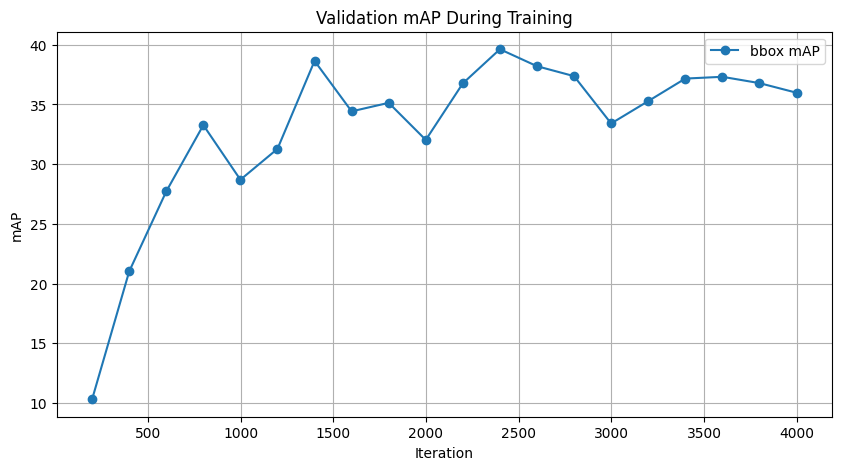

In [18]:
# ==================== PLOT mAP OVER ITERATIONS ====================
plt.figure(figsize=(10, 5))
plt.plot(df_log["iteration"], df_log["bbox/AP"], marker='o', label="bbox mAP")
plt.xlabel("Iteration")
plt.ylabel("mAP")
plt.title("Validation mAP During Training")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "map_during_training.png"))
plt.show()

In [19]:
# ==================== TRAIN SET EVALUATION ====================
evaluator_train = COCOEvaluator("my_dataset_train", cfg, False, output_dir=cfg.OUTPUT_DIR)
train_loader = build_detection_test_loader(cfg, "my_dataset_train")
train_metrics = inference_on_dataset(predictor.model, train_loader, evaluator_train)

print("Train Set Evaluation Metrics:", train_metrics)

# Save to JSON or CSV if needed
with open(os.path.join(cfg.OUTPUT_DIR, "train_evaluation_metrics.json"), "w") as f:
    json.dump(train_metrics, f, indent=4)

WARNING [04/07 16:18:36 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/07 16:18:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/07 16:18:36 d2.data.datasets.coco]: Loaded 157 images in COCO format from /kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/train/_annotations.coco.json
[04/07 16:18:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/07 16:18:36 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/07 16:18:36 d2.data.common]: Serializing 157 elements to byte tensors and concatenating them all ...
[04/07 16:18:36 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/07 16:18:36 d2.evaluation.evaluator

# Random test

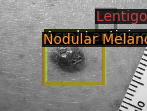

In [20]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [21]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [04/07 16:18:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/07 16:18:54 d2.data.datasets.coco]: Loaded 45 images in COCO format from /kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/valid/_annotations.coco.json
[04/07 16:18:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/07 16:18:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/07 16:18:54 d2.data.common]: Serializing 45 elements to byte tensors and concatenating them all ...
[04/07 16:18:54 d2.data.common]: Serialized dataset takes 0.02 MiB
[04/07 16:18:54 d2.evaluation.evaluator]: Start inference on 45 batches
[04/07 16:18:57 d2.evaluation.evaluator]: Inference done 29/45. Dataloading: 0.0018 s/iter. Inference: 0.1083 s/iter. Eval: 0.0002 s/iter. 

Load a new image and detect it.

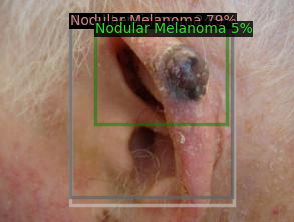

In [22]:
new_im = cv2.imread("/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/test/nm7-big__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd_jpg.rf.af478ea515e6196c781f303614f7d5c2.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

Process multiple images in a directory and save the results in an output directory

In [23]:
import os
import cv2
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

input_images_directory = "/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/test"
output_directory = "/kaggle/working/faster-rcnn/test_results"
os.makedirs(output_directory, exist_ok=True)

for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # 🚨 Skip if image can't be read
    if new_im is None:
        print(f"Skipping unreadable file: {image_filename}")
        continue

    outputs = predictor(new_im)

    v = Visualizer(new_im[:, :, ::-1], metadata=val_metadata, scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("✅ Detection completed for all readable images.")

Skipping unreadable file: _annotations.coco.json
✅ Detection completed for all readable images.


In [24]:
import csv
import os
import cv2

# Directory path to the input images folder
input_images_directory = "/kaggle/input/melanoma-cancer-for-od-in-coco-format/melanoma cancer.v1i.coco/test"

# Output CSV file path
output_csv_path = "/kaggle/working/faster-rcnn/test_results/output_objects.csv"

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Confidence", "BoundingBox"])

    # Loop over images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Skipping unreadable file: {image_filename}")
            continue

        # Run the prediction
        outputs = predictor(image)
        instances = outputs["instances"].to("cpu")

        pred_classes = instances.pred_classes.numpy()
        pred_boxes = instances.pred_boxes.tensor.numpy()
        scores = instances.scores.numpy()

        for i, (cls, box, score) in enumerate(zip(pred_classes, pred_boxes, scores)):
            class_name = val_metadata.thing_classes[cls]  # Use val_metadata or train_metadata as appropriate
            bbox = [int(coord) for coord in box]  # x1, y1, x2, y2
            csvwriter.writerow([image_filename, class_name, i + 1, round(score, 3), bbox])

print("✅ Object detection results saved to CSV.")

Skipping unreadable file: _annotations.coco.json
✅ Object detection results saved to CSV.


<ipython-input-25-f26c94b51708>:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)


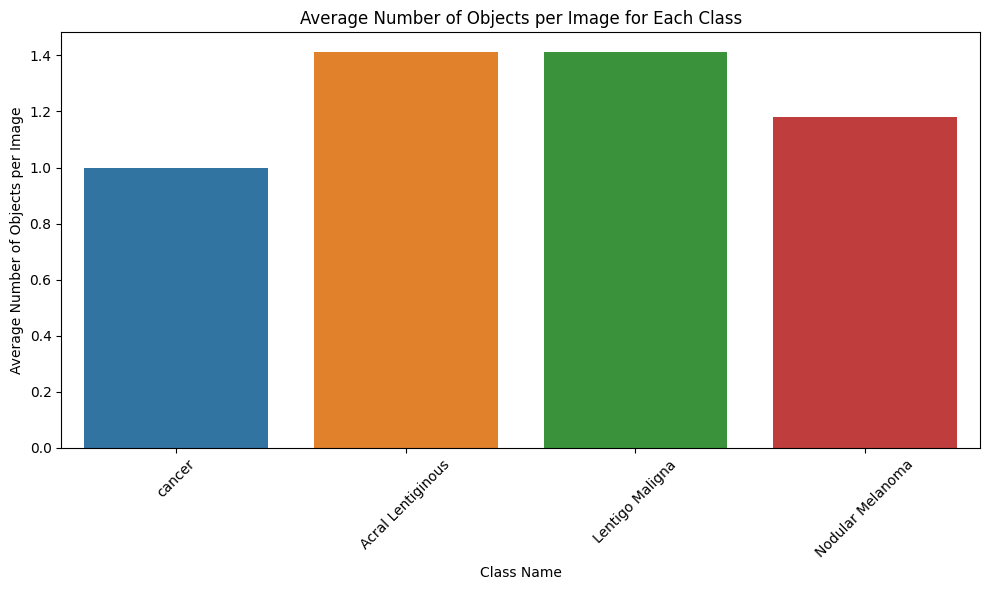

<ipython-input-25-f26c94b51708>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="bbox_area", data=avg_bbox_area_per_class, ci=None, order=class_names)


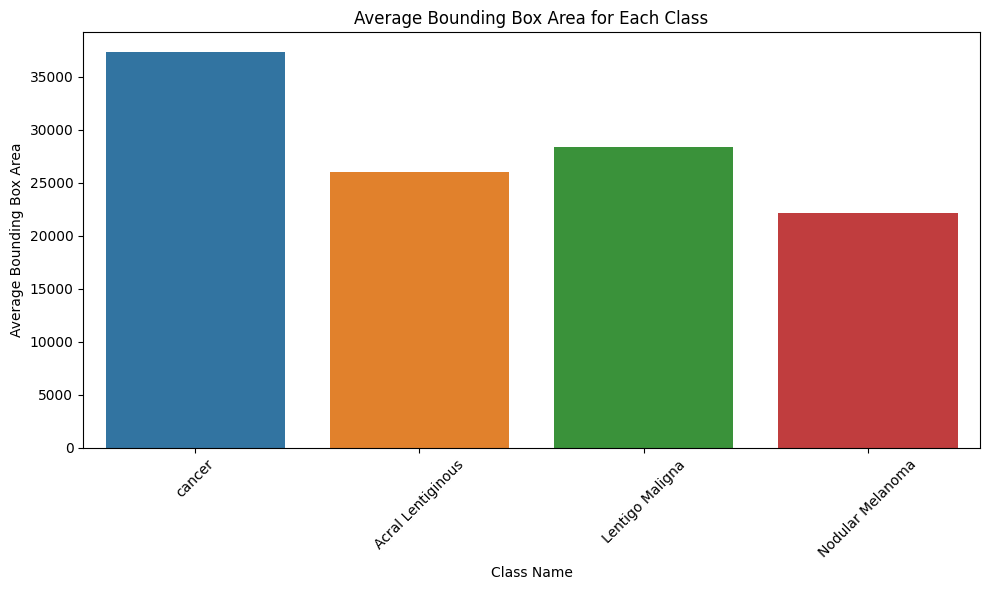

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
csv_file_path = "/kaggle/working/faster-rcnn/test_results/output_objects.csv"
df = pd.read_csv(csv_file_path)

# Get class names from your metadata
class_names = val_metadata.thing_classes  # or train_metadata if that's what you used

# ===================== Plot 1: Average number of objects per image =====================
# Count objects per image-class pair
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()

# ===================== Plot 2: Average bounding box area per class =====================
# Extract bounding box dimensions and calculate area
# BoundingBox column looks like: "[x1, y1, x2, y2]"
df["bbox_area"] = df["BoundingBox"].apply(lambda bbox: eval(bbox))  # Convert string to list
df["bbox_area"] = df["bbox_area"].apply(lambda box: (box[2] - box[0]) * (box[3] - box[1]))

# Average bounding box area per class
avg_bbox_area_per_class = df.groupby("Class Name")["bbox_area"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="bbox_area", data=avg_bbox_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Bounding Box Area")
plt.title("Average Bounding Box Area for Each Class")
plt.tight_layout()
plt.show()

# FLOPs

In [26]:
from detectron2.modeling import build_model
from detectron2.config import get_cfg
from detectron2 import model_zoo
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import torch

# Setup config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cpu"

# Build model
model = build_model(cfg)
model.eval()

# Dummy image (batch size = 1)
dummy_image = torch.randn(1, 3, 800, 800)

# Forward just the backbone (FPN + ResNet)
features = model.backbone(dummy_image)

# Use fvcore to compute FLOPs for the backbone
flops = FlopCountAnalysis(model.backbone, dummy_image)
print(f"Backbone FLOPs: {flops.total() / 1e9:.2f} GFLOPs")
print(parameter_count_table(model.backbone))

Backbone FLOPs: 60.18 GFLOPs
| name                    | #elements or shape   |
|:------------------------|:---------------------|
| model                   | 31.5M                |
|  fpn_lateral3           |  0.1M                |
|   fpn_lateral3.weight   |   (256, 512, 1, 1)   |
|   fpn_lateral3.bias     |   (256,)             |
|  fpn_output3            |  0.6M                |
|   fpn_output3.weight    |   (256, 256, 3, 3)   |
|   fpn_output3.bias      |   (256,)             |
|  fpn_lateral4           |  0.3M                |
|   fpn_lateral4.weight   |   (256, 1024, 1, 1)  |
|   fpn_lateral4.bias     |   (256,)             |
|  fpn_output4            |  0.6M                |
|   fpn_output4.weight    |   (256, 256, 3, 3)   |
|   fpn_output4.bias      |   (256,)             |
|  fpn_lateral5           |  0.5M                |
|   fpn_lateral5.weight   |   (256, 2048, 1, 1)  |
|   fpn_lateral5.bias     |   (256,)             |
|  fpn_output5            |  0.6M                |
| 